#🍎Hello in rotten fruit detection🍎

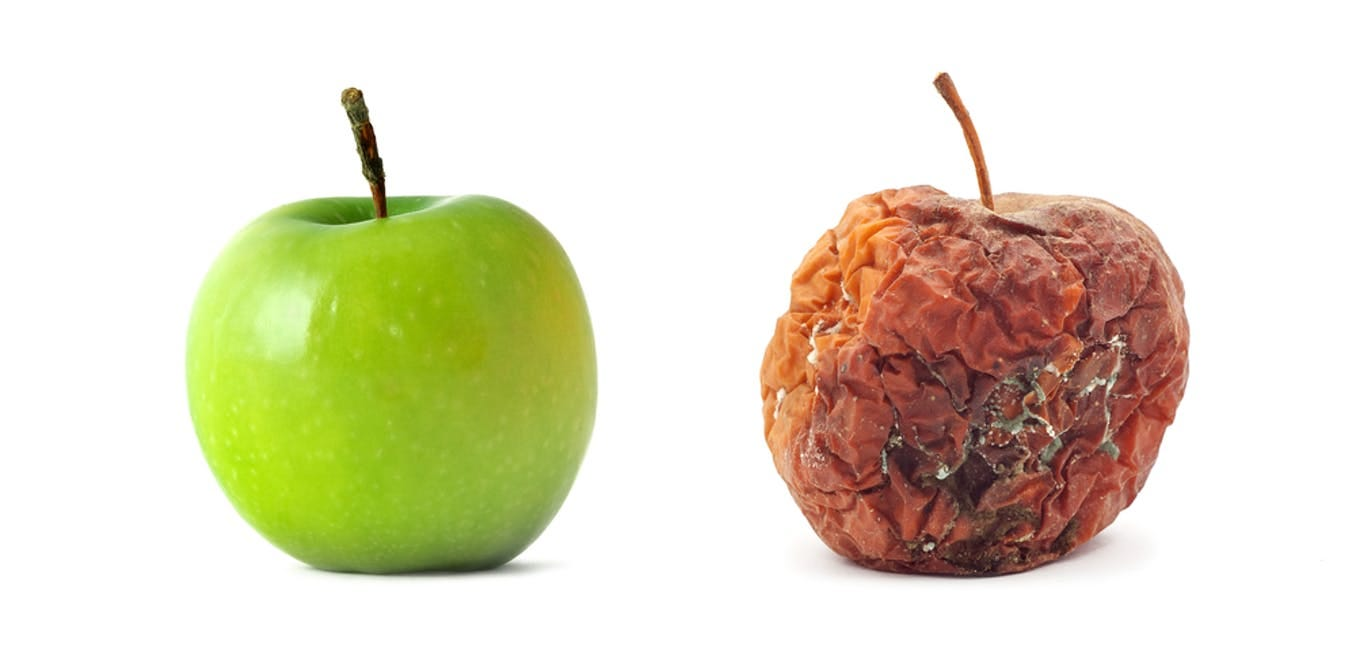


# about data
(strawberries, peaches, pomegranates) Photo requirements:

1-White background

2-.jpg

3- Image size 300*300

The number of photos required is 250 photos of each fruit when it is fresh and 250 photos of each fruit when it is rotten.
Total 1500 images


# extraxt data

In [5]:
from zipfile import ZipFile

file = ZipFile('/content/fruits-dataset-for-classification.zip')
file.extractall('data')

In [7]:
import os
DATA_PATH = 'data'
HOME = os.getcwd()

# import libaraies

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from splitfolders import ratio
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

from keras.applications import InceptionV3, VGG16, MobileNetV2
from keras.layers import Conv2D, Dropout, Dense, Flatten
from keras.models import Model, Sequential
from keras.callbacks import Callback

# plot some images

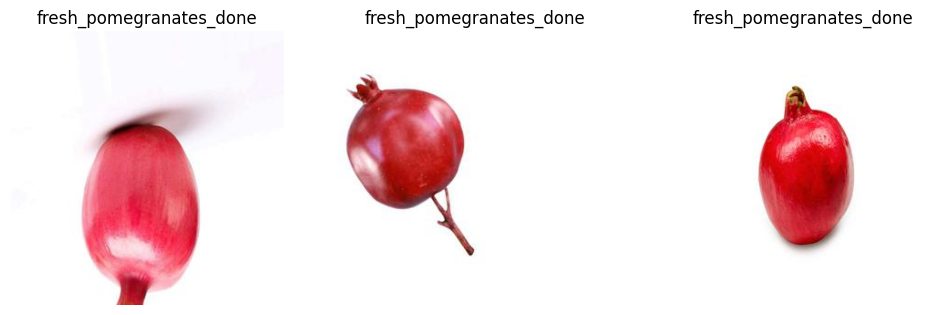

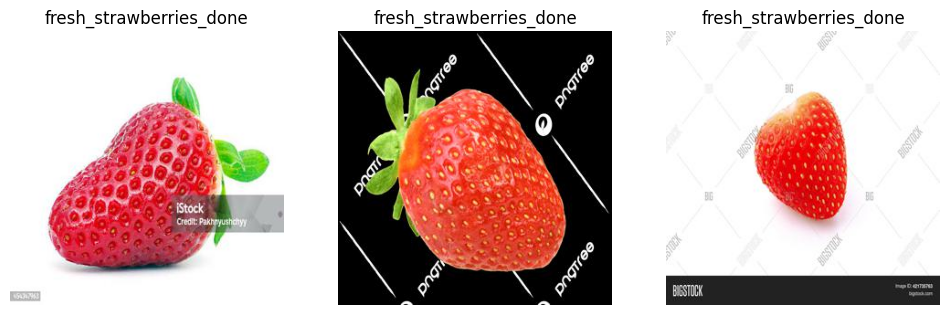

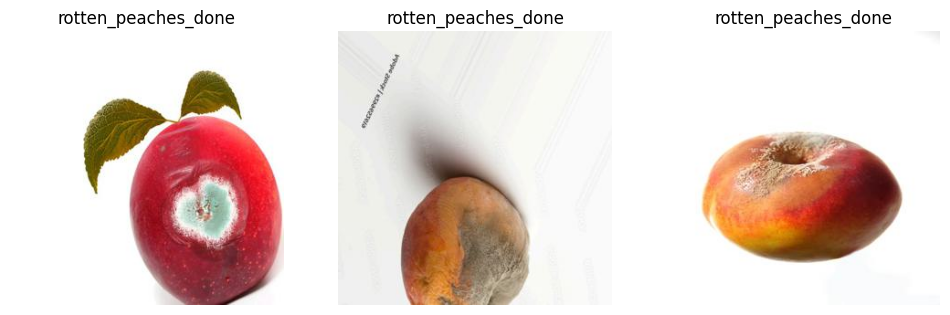

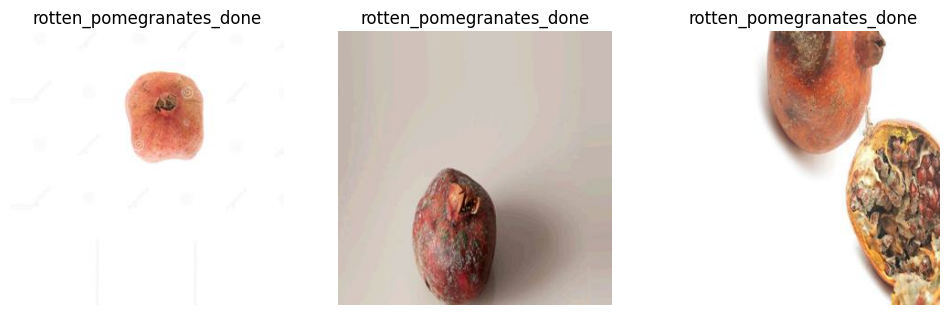

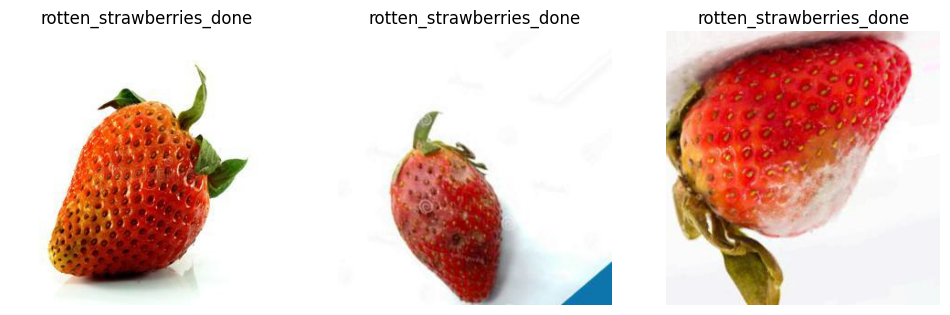

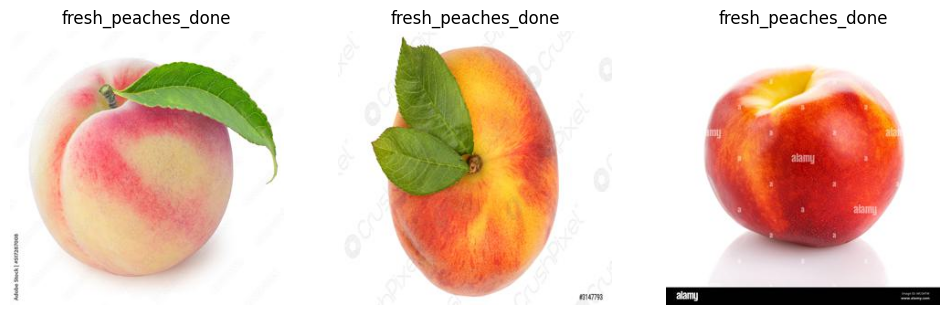

In [26]:
data_dir = os.listdir(DATA_PATH)
for dir in data_dir:
  image_folder = os.path.join(HOME, DATA_PATH, dir)
  image_files = os.listdir(image_folder)
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

  ax[0].imshow(plt.imread(os.path.join(image_folder, image_files[8])))
  ax[0].axis('off')
  ax[0].set_title(dir)

  ax[1].imshow(plt.imread(os.path.join(image_folder, image_files[4])))
  ax[1].axis('off')
  ax[1].set_title(dir)

  ax[2].imshow(plt.imread(os.path.join(image_folder, image_files[6])))
  ax[2].axis('off')
  ax[2].set_title(dir)



# split data into train, test, val

In [28]:
ratio(DATA_PATH, ratio=(0.8, 0.1, 0.1), output='new_data')

Copying files: 1655 files [00:00, 4543.08 files/s]


# preprocessing

In [32]:
train_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.4)
train_data = train_gen.flow_from_directory(os.path.join(HOME, 'new_data', 'train'),
                                           class_mode='categorical',
                                           batch_size=32,
                                           target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_directory(os.path.join(HOME, 'new_data', 'val'),
                                      class_mode='categorical',
                                      batch_size=32,
                                      target_size=(224, 224))

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(os.path.join(HOME, 'new_data', 'test'),
                                        class_mode='categorical',
                                        batch_size=32,
                                        target_size=(224, 224))

Found 1322 images belonging to 6 classes.
Found 165 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


# Build the model


In [80]:
class MyCallback(Callback):
    def __init__(self, target_val_accuracy=0.95):
        super(MyCallback, self).__init__()
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target_val_accuracy:
            print(f"\nReached target val accuracy of {self.target_val_accuracy*100}%!")
            self.model.stop_training = True

In [81]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed8')

x = Flatten()(last_layer.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

In [88]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_940 (Conv2D)         (None, 111, 111, 32)         864       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_940 (B  (None, 111, 111, 32)         96        ['conv2d_940[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_940 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

In [82]:
my_callback = MyCallback()

In [83]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_data, validation_data=val_data,
                 batch_size=32,
                 callbacks=[my_callback],
                 epochs=10)

Epoch 1/10
42/42 [==============================] - 34s 702ms/step - loss: 2.2467 - accuracy: 0.5726 - val_loss: 0.4447 - val_accuracy: 0.8485
Epoch 2/10
42/42 [==============================] - 17s 405ms/step - loss: 0.3245 - accuracy: 0.8828 - val_loss: 0.4142 - val_accuracy: 0.8485
Epoch 3/10
42/42 [==============================] - 17s 399ms/step - loss: 0.2017 - accuracy: 0.9304 - val_loss: 0.3482 - val_accuracy: 0.8909
Epoch 4/10
42/42 [==============================] - 18s 426ms/step - loss: 0.1278 - accuracy: 0.9599 - val_loss: 0.2624 - val_accuracy: 0.8909
Epoch 5/10
42/42 [==============================] - 17s 410ms/step - loss: 0.1147 - accuracy: 0.9652 - val_loss: 0.3909 - val_accuracy: 0.8788
Epoch 6/10
42/42 [==============================] - 18s 426ms/step - loss: 0.0884 - accuracy: 0.9735 - val_loss: 0.3415 - val_accuracy: 0.8970
Epoch 7/10
42/42 [==============================] - 17s 402ms/step - loss: 0.0647 - accuracy: 0.9773 - val_loss: 0.3135 - val_accuracy: 0.9030

# 🚀Visualize the model result in different ways🎶

# Saliency map
It helps you know if the model looks at the data well

In [85]:
def generate_saliency_map(model, input_image):
    input_tensor = model.input
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        class_output = prediction[:, tf.argmax(prediction[0])]

    gradients = tape.gradient(class_output, input_image)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)

    return saliency_map

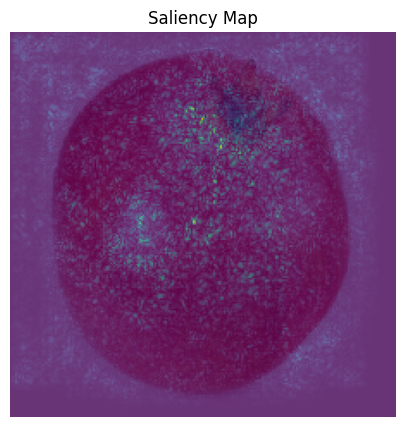

In [86]:
img = load_img('/content/new_data/test/fresh_pomegranates_done/fresh_pomegranate_191.jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array /= 255.0

saliency_map = generate_saliency_map(model, img_array)
saliency_map = np.array(saliency_map)
saliency_map = saliency_map.reshape((224, 224))

plt.figure(figsize=(10, 5))

plt.imshow(img)
plt.imshow(saliency_map, cmap='viridis', alpha=0.8)
plt.axis("off")
plt.title('Saliency Map')

plt.show()

# 🚀🚀Class Activation Map (CAM)
It helps you know if the model looks at the data well

In [98]:
img1 = load_img('/content/new_data/test/rotten_strawberries_done/rotten_strawberry_52.jpg', target_size=(224, 224))
img_array1 = img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, axis=0)
img_array1 /= 255.0

1/1 [==============================] - 2s 2s/step


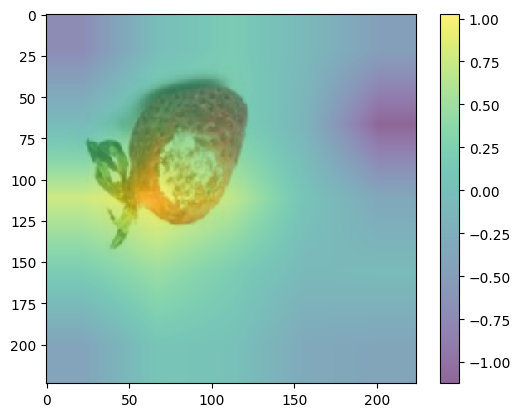

In [112]:
def generate_activation_map(model, image, layer_name, size):
  layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  activations = layer_model.predict(image)
  activations = cv2.resize(activations[0, :, :, 0], size)
  return activations


cam_img = generate_activation_map(model, img_array1, 'conv2d_1015', (224, 224))
plt.imshow(img1)
plt.imshow(cam_img, cmap='viridis', alpha=0.6)
plt.colorbar()
plt.show()

# ✈️🚀Evaluate the Model

# training and testing loss

In [100]:
train = model.evaluate(train_data)

print(f"train loss : {train[0] *100 :.2f} %")
print(f"train accuracy : {train[1] *100 :.2f} %")

print("*" * 20)

test = model.evaluate(test_data)

print(f"test loss : {test[0] *100 :.2f} %")
print(f"test accuracy : {test[1] *100 :.2f} %")

42/42 [==============================] - 17s 397ms/step - loss: 0.0204 - accuracy: 0.9977
train loss : 2.04 %
train accuracy : 99.77 %
********************
6/6 [==============================] - 0s 64ms/step - loss: 0.3876 - accuracy: 0.8929
test loss : 38.76 %
test accuracy : 89.29 %


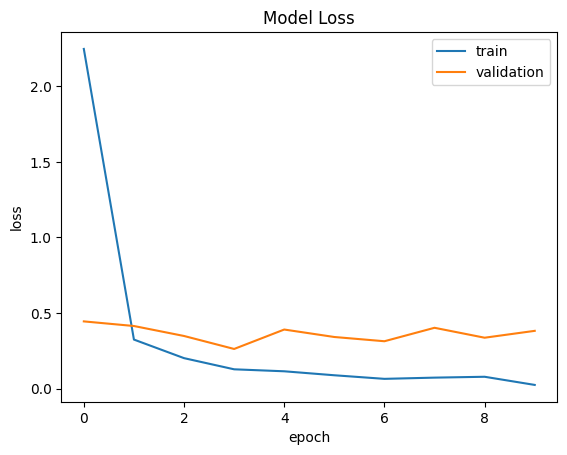

In [107]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

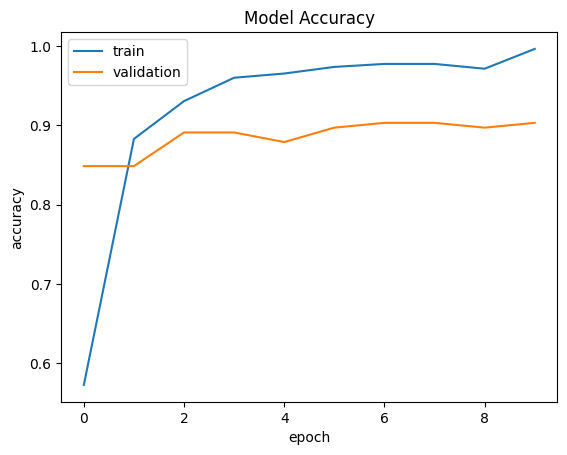

In [106]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()